/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.3566 - val_loss: 0.1012 - learning_rate: 1.0000e-04
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1062 - val_loss: 0.0759 - learning_rate: 1.0000e-04
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0905 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0848 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0810 - val_loss: 0.0671 - learning_rate: 1.0000e-04
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0781 - val_loss: 0.0625 - learning_rate: 1.0000e-04
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0762 - val_loss: 0.0596 - learning_rate: 1.0000e-04
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0753 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0721 - val_loss: 0.0581 -

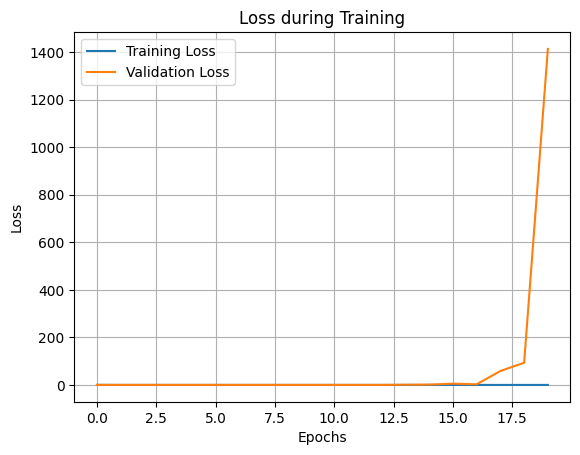

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0631
Test Loss (MSE): 0.045238226652145386
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


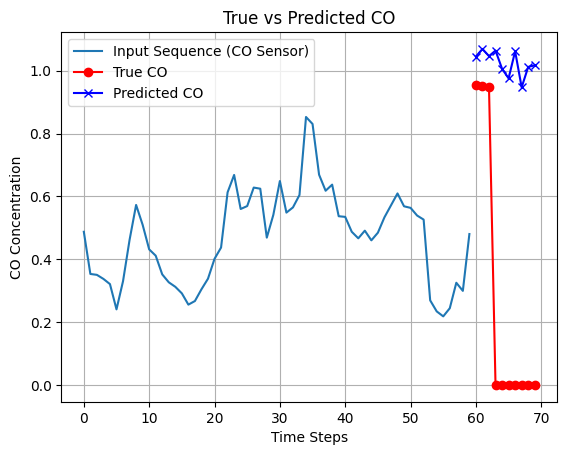

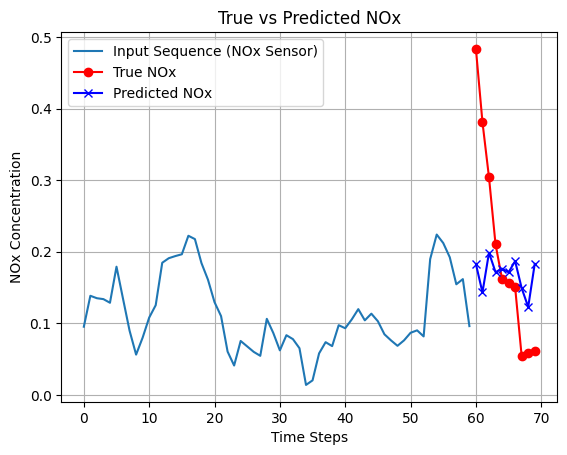

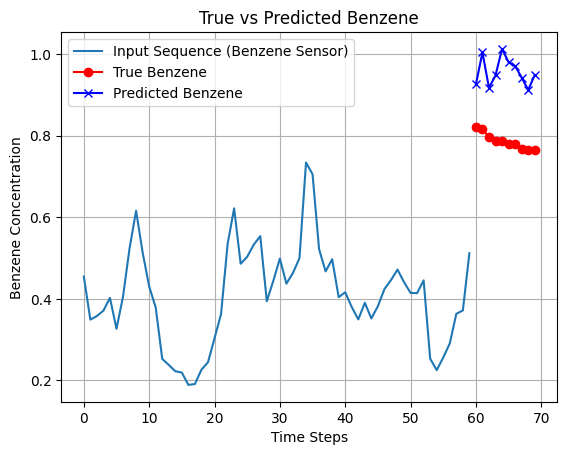

Test MSE for CO: 0.10000283774829992
Test MSE for Benzene: 0.016161047273174568
Test MSE for NOx: 0.019550779784329585


In [1]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow import keras

# Load the train and test datasets
X_train = pd.read_csv('AirQuality_X_train.csv')
y_train = pd.read_csv('AirQuality_Y_train.csv')
X_test = pd.read_csv('AirQuality_X_test.csv')
y_test = pd.read_csv('AirQuality_Y_test.csv')

# Convert DataFrames to NumPy arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# Scaling the features and targets using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Define the number of time steps and sequence length for input/output
n_steps = 60  # 60 hours for input
n_outputs = 10  # Predict the next 10 hours
n_features = X_train.shape[1]

# Reshape data to 3D format for RNN/LSTM input
def create_sequences(X, Y, n_steps, n_outputs):
    Xs, Ys = [], []
    for i in range(len(X) - n_steps - n_outputs):
        Xs.append(X[i:(i + n_steps), :])
        Ys.append(Y[(i + n_steps):(i + n_steps + n_outputs), :])
    return np.array(Xs), np.array(Ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps, n_outputs)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps, n_outputs)

# Building the Model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_outputs * 3))  # 10 time steps for 3 outputs
model.add(keras.layers.Reshape((n_outputs, 3)))  # Reshape to match (10, 3) output shape

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with early stopping
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, lr_schedule])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.show()

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (MSE): {test_loss}")

# Forecast the next 10 time steps for a sample test sequence
y_pred = model.predict(X_test_seq)

# Plot true vs predicted values for CO
plt.plot(range(n_steps), X_test_seq[0, :, 0], label='Input Sequence (CO Sensor)')
plt.plot(range(n_steps, n_steps + n_outputs), y_test_seq[0, :, 0], 'ro-', label='True CO')
plt.plot(range(n_steps, n_steps + n_outputs), y_pred[0, :, 0], 'bx-', label='Predicted CO')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("CO Concentration")
plt.title("True vs Predicted CO")
plt.show()

# Plot true vs predicted values for NOx
plt.plot(range(n_steps), X_test_seq[0, :, 2], label='Input Sequence (NOx Sensor)')
plt.plot(range(n_steps, n_steps + n_outputs), y_test_seq[0, :, 2], 'ro-', label='True NOx')
plt.plot(range(n_steps, n_steps + n_outputs), y_pred[0, :, 2], 'bx-', label='Predicted NOx')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("NOx Concentration")
plt.title("True vs Predicted NOx")
plt.show()

# Plot true vs predicted values for Benzene (C6H6)
plt.plot(range(n_steps), X_test_seq[0, :, 1], label='Input Sequence (Benzene Sensor)')
plt.plot(range(n_steps, n_steps + n_outputs), y_test_seq[0, :, 1], 'ro-', label='True Benzene')
plt.plot(range(n_steps, n_steps + n_outputs), y_pred[0, :, 1], 'bx-', label='Predicted Benzene')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("Benzene Concentration")
plt.title("True vs Predicted Benzene")
plt.show()

# Evaluate MSE for each pollutant individually
mse_co = mean_squared_error(y_test_seq[:, :, 0], y_pred[:, :, 0])
mse_benzene = mean_squared_error(y_test_seq[:, :, 1], y_pred[:, :, 1])
mse_nox = mean_squared_error(y_test_seq[:, :, 2], y_pred[:, :, 2])

print(f"Test MSE for CO: {mse_co}")
print(f"Test MSE for Benzene: {mse_benzene}")
print(f"Test MSE for NOx: {mse_nox}")
